In [1]:
# This notebook runs from the projects root directory.
import os
PROJECT_ROOT_DIRECTORY = 'senior_project'
while os.path.basename(os.getcwd()) != PROJECT_ROOT_DIRECTORY:
    os.chdir(os.pardir)
print('Current working directory:', os.getcwd())

Current working directory: c:\Users\pavan\Desktop\senior_project


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
from stable_baselines3 import DQN, A2C
from environments.discrete_env_v2 import PortfolioManagementEnv
from experiments.utils import evaluate_results

In [3]:
experiment_id = 'EXPERIMENT_1_1678523209'

In [4]:
train_df = pd.read_csv('data\dow_10_returns_train.csv', index_col=0, parse_dates=True)
val_df = pd.read_csv('data\dow_10_returns_val.csv', index_col=0, parse_dates=True)

TICKERS = ['AXP', 'AAPL', 'BA', 'GS', 'INTC', 'JNJ', 'KO', 'NKE', 'PG', 'DIS']
RETURN_COLS = ['RF_RETURN'] + [f'{ticker}_RETURN' for ticker in TICKERS]
FEATURE_COLS = RETURN_COLS

In [5]:
train_env = PortfolioManagementEnv(
    train_df, 
    RETURN_COLS, 
    FEATURE_COLS, 
    window_size = 20,
    episode_length = -1
)

val_env = PortfolioManagementEnv(
    val_df, 
    RETURN_COLS, 
    FEATURE_COLS, 
    window_size = 20,
    episode_length = -1
)

In [6]:
envs = (train_env, val_env)
model_numbers = (60_000, 110_000, 200_000, 340_000, 600_000)

0it [00:00, ?it/s]

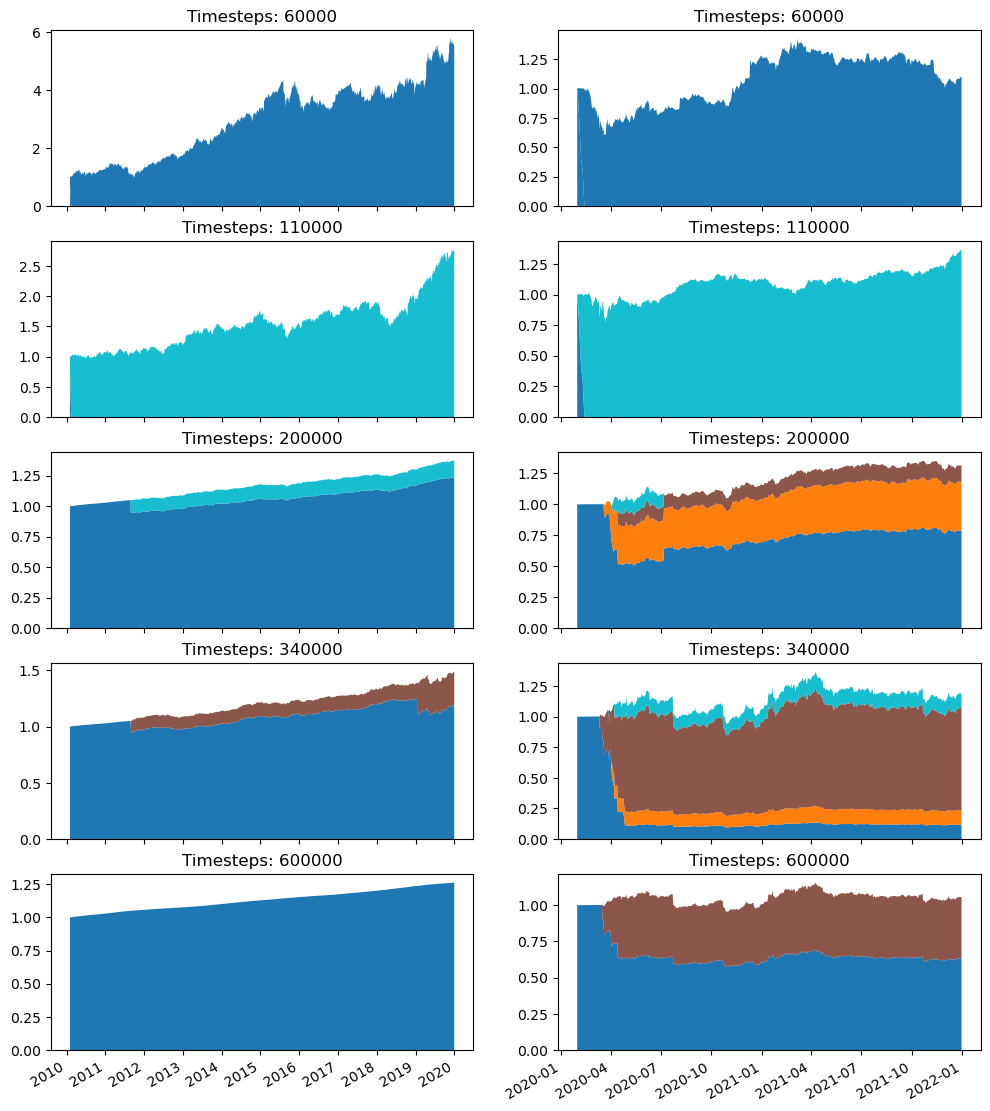

In [7]:
fig, axes = plt.subplots(len(model_numbers), len(envs), figsize=(6*len(envs), 3*len(model_numbers))) # each figure is 6 by 3
for i,model_number in tqdm(enumerate(model_numbers)):
    model = A2C.load(f'experiments/models/{experiment_id}/{model_number}')
    for j,env in enumerate(envs):
        obs, done = env.reset(), False
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
        env.render(axes[i,j], title=f'Timesteps: {model_number}')
        env.close()

In [8]:
results_df = pd.read_csv('experiments/results_df.csv', index_col=0, parse_dates=True)

timesteps_to_save = (600_000,)
for timestep in timesteps_to_save:
    env = val_env
    obs, done = env.reset(), False
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
    env.close()
    
    results_df[f'{experiment_id}_{timestep}'] = env.get_portfolio_returns()

<span style="color:red">**(RUN ONCE)**</span>

In [17]:
# results_df.to_csv('experiments/results_df.csv')

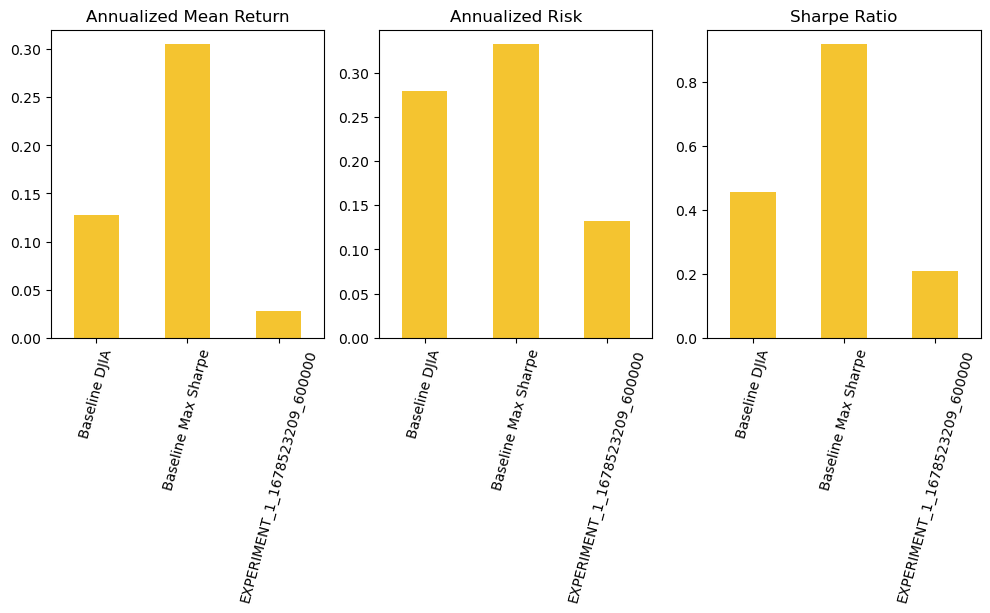

In [19]:
evaluate_results(
    results_df.dropna(),
    plot_metrics=['Annualized Mean Return', 'Annualized Risk', 'Sharpe Ratio'],
    rot=75
);